In [161]:
from math import log, exp, sqrt, sin, cos, pi
import numpy
from numpy import split, array, arctan, mean, zeros, sin, cos, pi, arange, concatenate

import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed, Bidirectional, Dropout


from pmdarima.utils import diff_inv

import matplotlib
from matplotlib import pyplot

pyplot.style.use('ggplot')

from IPython.display import Image 
import datetime, os

# Load the TensorBoard notebook extension
#%load_ext tensorboard
pyplot.rcParams['figure.dpi'] = 100
pyplot.rcParams['figure.figsize'] = [12,5]
matplotlib.rc('lines', linewidth=1, linestyle='-')

In [162]:
#%reload_ext tensorboard

In [163]:
# invert difference
def invert_difference(orig_data, diff_data, interval):
    union = concatenate((orig_data, diff_data), axis=None)
    for i in range(interval,len(union)):
        union[i] = union[i] + union[i-interval]
    return union[interval:]

In [164]:
# MAAPE metric -> does not have the same behaviour as MAPE for actual values close to zero, which is good

def mean_arctangent_absolute_percentage_error(actual, predicted):

    return mean(arctan(abs((actual - predicted) / actual))) * 100

In [165]:
# train the model
def build_model(train, n_input, n_output, stride):
    # prepare data
    train_x, train_y = to_supervised(train, n_input, n_output, stride)
    # Model variables
    verbose, epochs, batch_size = 1, 50, 0
    n_timesteps, n_features = train_x.shape[1], train_x.shape[2]
    
    # final data preparation for the model
    # reshape output into [samples, timesteps, features] for the LSTMs
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1], 1)
    
    # define model
    model = Sequential()
    # LSTM - LSTM
    
    model.add(LSTM(32, activation='tanh', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_output))
    model.add(LSTM(32, activation='tanh'))
    model.add((Dense(32, activation='relu')))   # Reminder: Other activation fuctions?
    model.add((Dense(16, activation='relu')))
    model.add((Dense(n_output)))
    
    
    # CNN - LSTM
    """
    n_filters = 32
    k_size = 5
    p_size = n_features
    model.add(Conv1D(filters=n_filters, kernel_size=k_size, activation='relu', input_shape=(n_timesteps, n_features), padding='same'))
    model.add(Conv1D(filters=n_filters, kernel_size=k_size, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=p_size, padding='same'))
    model.add(Flatten())
    model.add(RepeatVector(n_output))
    model.add(LSTM(100, activation='tanh'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_output))
    """
    
    model.compile(loss="mse", optimizer='adam', metrics=["mae"])  # Reminder: LOSS function is MSE but others can be used!
    
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))  
    tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    early = tensorflow.keras.callbacks.EarlyStopping('loss', patience=3)

    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[tensorboard_callback, early])
    print(model.summary())

    return model

In [166]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    # Plot rolling statistics:
    orig = pyplot.plot(timeseries, color='blue', label='Original')
    mean = pyplot.plot(rolmean, color='red', label='Rolling Mean')
    std = pyplot.plot(rolstd, color='black', label='Rolling Std')
    pyplot.legend(loc='best')
    pyplot.title('Rolling Mean & Standard Deviation')
    pyplot.show(block=False) 

    # Perform the augmented Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [167]:
# load the csv file
# ../30min/30minstore290.csv
# ../30min/30minstore1027.csv
# ../30min/30minstore274.csv
# special case01: ../30min/partial_covid_stationary_sliced_30minstore274.csv
# special case02: ../30min/full_covid_nonstationary_sliced_30minstore274.csv
# predict covid:  ../30min/predict_covid_30minstore274
dataset = pd.read_csv('../30min/partial_covid_stationary_sliced_30minstore274.csv', header=0, infer_datetime_format=True,
                   parse_dates=['datetime'], index_col=['datetime'])

#dataset = dataset.drop(['store', 'products_sold', 'sales', 'weekday', 'halfhour', 'year', 'day', 'month'], axis=1)
dataset = dataset[['clients_that_bought']]

print(dataset)

                     clients_that_bought
datetime                                
2020-03-18 08:30:00                   30
2020-03-18 09:00:00                   41
2020-03-18 09:30:00                   36
2020-03-18 10:00:00                   26
2020-03-18 10:30:00                   21
...                                  ...
2020-05-26 18:30:00                   17
2020-05-26 19:00:00                   11
2020-05-26 19:30:00                   15
2020-05-26 20:00:00                   13
2020-05-26 20:30:00                   12

[1750 rows x 1 columns]


In [168]:
# PARAMETERS
n_input = 50                 # steps used to predict (autoregressive order)
n_output = 700               # steps to predict (forecast horizon)
data_split = n_output        # to split the data in windows
stride = 1                   # stride value for the sliding window method (overlapped vs non-overlapped)
test_set = 700               # last observations for the test_set
init_train_set = 0           # refers to when the train_set starts, this is useful for the sliding window method
walkforward = True           # walkforward validation 1 / 0

time_features = False        # Cosine and Sine time waves as features, REQUIRES PREVIOUS STUDY!

encode_weekday = False       # If the string weekday is included in the dataset


# If there is a seasonal component, test if it should be removed! ADF only tests trend stationarity!
# Valid for univariate so far
# Also requires previous study
diff_order = 0

# Remove seasonality (and trend if necessary)
remove_components = False
# IMPORTANT WARNING! 
# If n_output is too large and there's not enough train data to split, 
# consider having a one shot large prediction without splitting
# This is used when the train/test ratio is 50(or less)/50 and walkforward is not required!
single_prediction = True
# the changes if a large single prediction is conducted
if single_prediction:
    walkforward = False
    test_set = n_output
    data_split = 1
    
print("Train beginning:\n")
print(dataset.iloc[init_train_set])
print("\nTrain end:\n")
print(dataset.iloc[-test_set-1])
print("\nTest beggining:\n")
print(dataset.iloc[-test_set])
print("\nTest end:\n")
print(dataset.iloc[-1])

print("\nParameters:    n_input / n_output / stride")
print(n_input, n_output, stride)

Train beginning:

clients_that_bought    30
Name: 2020-03-18 08:30:00, dtype: int64

Train end:

clients_that_bought    16
Name: 2020-04-28 20:30:00, dtype: int64

Test beggining:

clients_that_bought    15
Name: 2020-04-29 08:30:00, dtype: int64

Test end:

clients_that_bought    12
Name: 2020-05-26 20:30:00, dtype: int64

Parameters:    n_input / n_output / stride
50 700 1


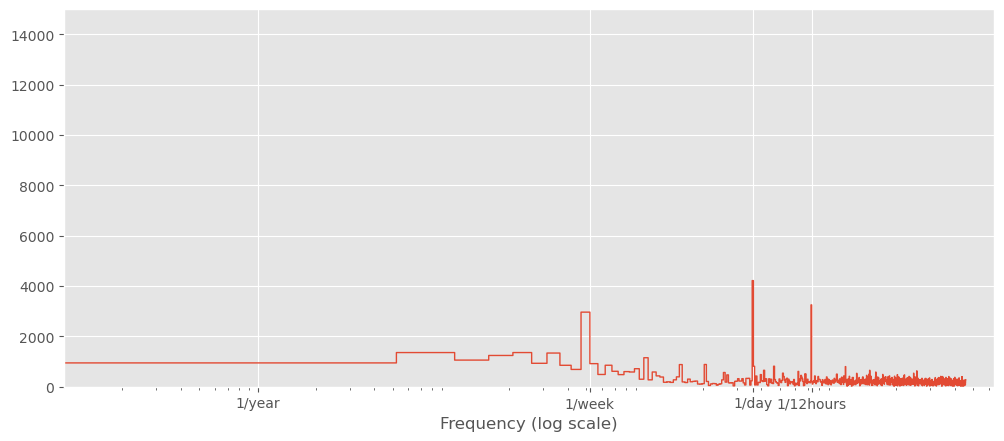

In [169]:
# Time Features

# Configurable: in Chapter example a day is 25 half hours
dataset_day = 25

date_time = dataset.index

# Convert time to seconds
timestamp_s = date_time.map(datetime.datetime.timestamp)

fft = tensorflow.signal.rfft(dataset['clients_that_bought'])
f_per_dataset = arange(0, len(fft))

n_samples_h = len(dataset['clients_that_bought'])
hours_per_year = dataset_day*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
pyplot.step(f_per_year, numpy.abs(fft))
pyplot.xscale('log')
pyplot.ylim(0, 15000)
pyplot.xlim([0.1, max(pyplot.xlim())])
pyplot.xticks([1, 52.1428571429, 365.2524, 730.5048], labels=['1/year', '1/week', '1/day', '1/12hours'])
_ = pyplot.xlabel('Frequency (log scale)')
pyplot.show()


if time_features:
    # Check important frequencies -> seasonality with the sine and cosine waves
    
    # This calculations are necessary because datetime was converted to seconds!
    day = dataset_day*30*60
    half_day = day // 2
    week = 7*day
    month = 4*week
    
    """
    dataset['day sin'] = sin(timestamp_s * (2 * pi / day))
    dataset['day cos'] = cos(timestamp_s * (2 * pi / day))
    dataset['halfday sin'] = sin(timestamp_s * (2 * pi / half_day))
    dataset['halfday cos'] = cos(timestamp_s * (2 * pi / half_day))
    dataset['week sin'] = sin(timestamp_s * (2 * pi / week))
    dataset['week cos'] = cos(timestamp_s * (2 * pi / week))
    dataset['month sin'] = sin(timestamp_s * (2 * pi / month))
    dataset['month cos'] = cos(timestamp_s * (2 * pi / month))
    print(dataset)
    
    pyplot.plot(array(dataset['day sin'])[:dataset_day])
    pyplot.plot(array(dataset['day cos'])[:dataset_day])
    pyplot.xlabel('Time [hh]')
    pyplot.title('Time of day signal')
    pyplot.show()
    
    pyplot.plot(array(dataset['halfday sin'])[:dataset_day//2])
    pyplot.plot(array(dataset['halfday cos'])[:dataset_day//2])
    pyplot.xlabel('Time [hh]')
    pyplot.title('Time of halfday signal')
    pyplot.show()
    
    pyplot.plot(array(dataset['week sin'])[:dataset_day*7])
    pyplot.plot(array(dataset['week cos'])[:dataset_day*7])
    pyplot.xlabel('Time [hh]')
    pyplot.title('Time of week signal')
    pyplot.show()
    
    pyplot.plot(array(dataset['month sin'])[:dataset_day*30])
    pyplot.plot(array(dataset['month cos'])[:dataset_day*30])
    pyplot.xlabel('Time [hh]')
    pyplot.title('Time of month signal')
    pyplot.show()
    """

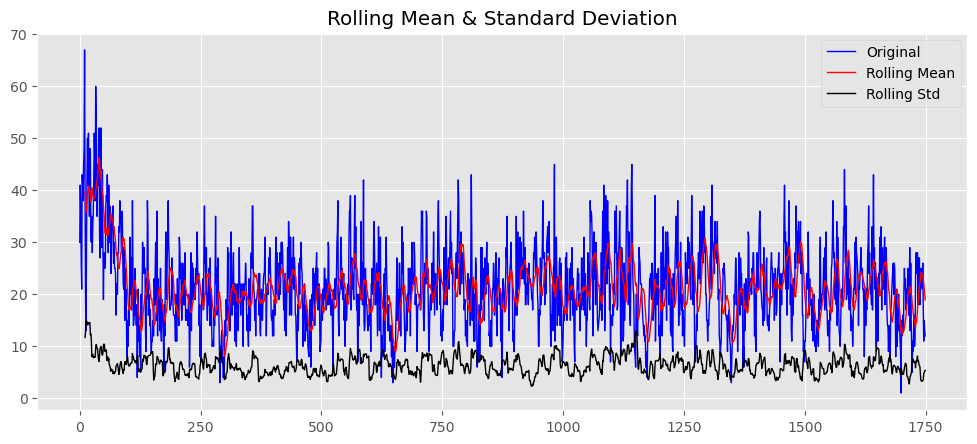

Results of Dickey-Fuller Test:
Test Statistic                   -4.471738
p-value                           0.000221
#Lags Used                       25.000000
Number of Observations Used    1724.000000
Critical Value (1%)              -3.434149
Critical Value (5%)              -2.863218
Critical Value (10%)             -2.567663
dtype: float64


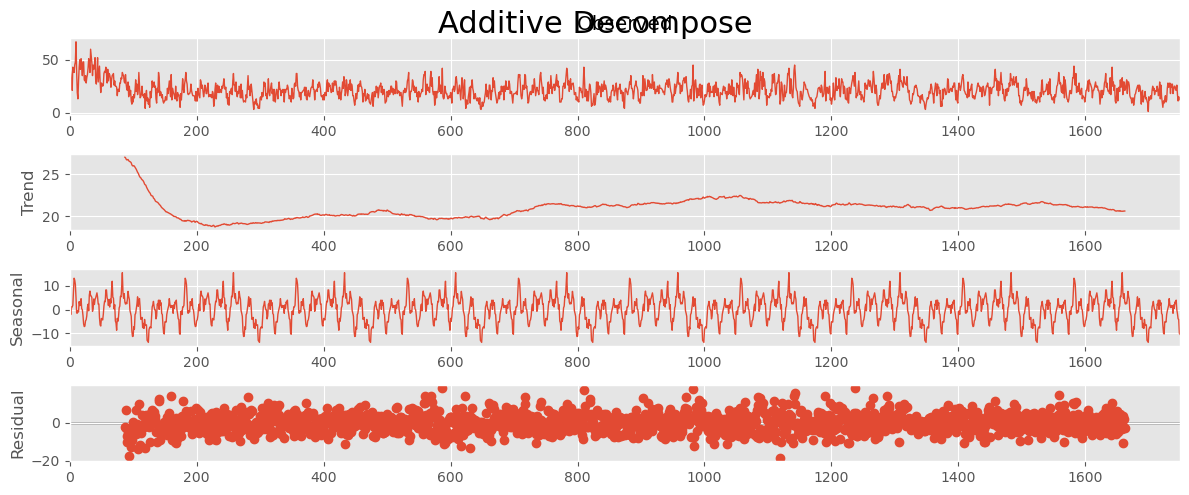

In [170]:
# Check components and stationarity of the forecast variable
forecast_variable = dataset['clients_that_bought'].values

# Test stationarity
test_stationarity(forecast_variable)

# Additive Decomposition
result_add = seasonal_decompose(forecast_variable, model='additive', period=175)

# Plot components

result_add.plot().suptitle('Additive Decompose', fontsize=22)
pyplot.show()

In [171]:
# Differencing
# change code later,
# FOR NOW it is only compatible with univariate single predictions
orig_dataset = dataset['clients_that_bought'].values
if diff_order > 0:
    diff_dataset = pd.DataFrame()
    diff_dataset['diff_clients_that_bought'] = dataset['clients_that_bought'].diff(diff_order)

    # in case there are more features
    diff_dataset = pd.concat([diff_dataset,dataset], axis=1)
    diff_dataset = diff_dataset.drop(['clients_that_bought'], axis=1)
    dataset = diff_dataset.dropna()
    
    # Test stationarity after differencing
    
    # Check components and stationarity of the forecast variable
    forecast_variable = dataset['diff_clients_that_bought'].values
    test_stationarity(forecast_variable)

    # Additive Decomposition
    result_add = seasonal_decompose(forecast_variable, model='additive', extrapolate_trend='freq', period=25)

    # Plot components
    result_add.plot().suptitle('Additive Decompose', fontsize=22)
    pyplot.show()
    print(dataset)

In [172]:
if remove_components:
    # Remove trend and seasonality, regression with fourier terms!
    forecast_variable = dataset.reset_index().drop(['datetime'],axis=1)
    print(forecast_variable)

    # Time scale
    predic1 = range(len(dataset))
    k_day=1
    k_week=1
    k_halfday=1
    #Applying the Fourier series to the time scale
    predic_day_cos = list(map(lambda x: cos(2*k_day*pi*x/25), predic1))
    predic_day_sin = list(map(lambda x: sin(2*k_day*pi*x/25), predic1))

    predic_week_cos = list(map(lambda x: cos(2*k_week*pi*x/175), predic1))
    predic_week_sin = list(map(lambda x: sin(2*k_week*pi*x/175), predic1))

    predic_halfday_cos = list(map(lambda x: cos(2*k_halfday*pi*x/12.5), predic1))
    predic_halfday_sin = list(map(lambda x: sin(2*k_halfday*pi*x/12.5), predic1))

    # Assembling the regressors
    reg = pd.DataFrame(list(zip(predic1, predic_day_cos, predic_day_sin, predic_week_cos, predic_week_sin, predic_halfday_cos, predic_halfday_sin)), 
                   columns =['predic1', 'predic_day_cos', 'predic_day_sin', 'predic_week_cos', 'predic_week_sin', 'predic_halfday_cos', 'predic_halfday_sin'])

    #reg = reg[['predic1', 'predic_day_cos', 'predic_day_sin', 'predic_week_cos', 'predic_week_sin']]
    # Linear regression
    model = LinearRegression().fit(reg, forecast_variable)

    #The estimated parameters
    r2 = model.score(reg, forecast_variable)
    print('coefficient of determination:', r2)


    trend = model.intercept_ + model.coef_[0][0]*array(predic1)
    seas_day = model.coef_[0][1]*array(predic_day_cos) + model.coef_[0][2]*array(predic_day_sin)
    seas_week = model.coef_[0][3]*array(predic_week_cos) + model.coef_[0][4]*array(predic_week_sin)
    seas_halfday = model.coef_[0][5]*array(predic_halfday_cos) + model.coef_[0][6]*array(predic_halfday_sin)

    trend_seas = trend + seas_day  + seas_week + seas_halfday

    ax = pd.DataFrame(trend_seas, columns=['trend+seasonalities']).plot(figsize=(20,8))
    forecast_variable.plot(ax=ax,alpha=0.7)

    y_adjusted = array(list(forecast_variable['clients_that_bought'])) - trend_seas
    y_adjusted = pd.DataFrame(y_adjusted, columns=['noise'])
    print(y_adjusted)
    y_adjusted.plot(figsize=(20,8))
    
    y_adjusted = y_adjusted.set_index(dataset.index)
    dataset = dataset.assign(clients_that_bought=y_adjusted['noise'])
    components = trend_seas
    print(y_adjusted, dataset, len(components))

In [173]:
values = dataset.values
# Encode weekday
if encode_weekday:
    encoder = LabelEncoder()
    values[:, 1] = encoder.fit_transform(values[:, 1])

# ensure all data is float
values = values.astype('float32')

print(values.shape)

(1750, 1)


In [174]:
# split into train and test, leave the last test_set blocks for n_output timesteps
train, test = values[init_train_set:-test_set], values[-test_set:]  

# Normalization
scaler = StandardScaler() #MinMaxScaler(feature_range=(0, 1)) 
train = scaler.fit_transform(train)
test = scaler.transform(test)

#for walkforward
def normalize_train(scaler, train):
    train = scaler.fit_transform(train)
    return train

# restructure into windows, for the sliding window method
train = array(split(train, len(train) / data_split))
test = array(split(test, len(test) / n_output))
print(train.shape, test.shape)

(1050, 1, 1) (1, 700, 1)


In [175]:
# convert history into inputs and outputs - framing to a supervised learning problem
def to_supervised(train, n_input, n_output, stride=1):
    # flatten data
    data = train.reshape(train.shape[0] * train.shape[1], train.shape[2])
    train_x, train_y = list(), list()
    in_start = 0
    # step over the entire history one STRIDE step at a time
    for _ in range(0, len(data), stride):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_output
        # ensure we have enough data for this instance
        if out_end <= len(data):
            #print("iteration")
            #print(_)
            #print("x")
            #print(in_start,in_end)
            #print("y")
            #print(in_end,out_end)
            train_x.append(data[in_start:in_end, :])
            train_y.append(data[in_end:out_end, 0])
        # move along stride time steps
        in_start += stride
    print(array(train_x).shape, array(train_y).shape)
    return array(train_x), array(train_y)

In [176]:
# make the multi-step forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
    
    # retrieve last n_input observations to predict with
    input_x = data[-n_input:, :]
    
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    
    # forecast the next n_output steps
    yhat = model.predict(input_x, verbose=0)

    # we only want the forecast variable
    yhat = yhat[0]
    return yhat

In [177]:
# invert the scaling
def invTransformTarget(scaler, data):
    dummy = pd.DataFrame(zeros((len(data), scaler.n_features_in_)))
    dummy[0] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=dummy.columns)
    return dummy[0].values

walkforward expanding: 1
total expansions: 1
(301, 50, 1) (301, 700)
Epoch 1/50
10/10 [==============================] - 6s 350ms/step - loss: 0.7166 - mae: 0.6729
Epoch 2/50
10/10 [==============================] - 2s 198ms/step - loss: 0.7109 - mae: 0.6689
Epoch 3/50
10/10 [==============================] - 2s 185ms/step - loss: 0.7017 - mae: 0.6620
Epoch 4/50
10/10 [==============================] - 2s 180ms/step - loss: 0.6908 - mae: 0.6544
Epoch 5/50
10/10 [==============================] - 2s 183ms/step - loss: 0.6780 - mae: 0.6463
Epoch 6/50
10/10 [==============================] - 2s 182ms/step - loss: 0.6669 - mae: 0.6405
Epoch 7/50
10/10 [==============================] - 2s 190ms/step - loss: 0.6548 - mae: 0.6342
Epoch 8/50
10/10 [==============================] - 2s 197ms/step - loss: 0.6455 - mae: 0.6304
Epoch 9/50
10/10 [==============================] - 2s 193ms/step - loss: 0.6261 - mae: 0.6209
Epoch 10/50
10/10 [==============================] - 2s 193ms/step - loss: 0

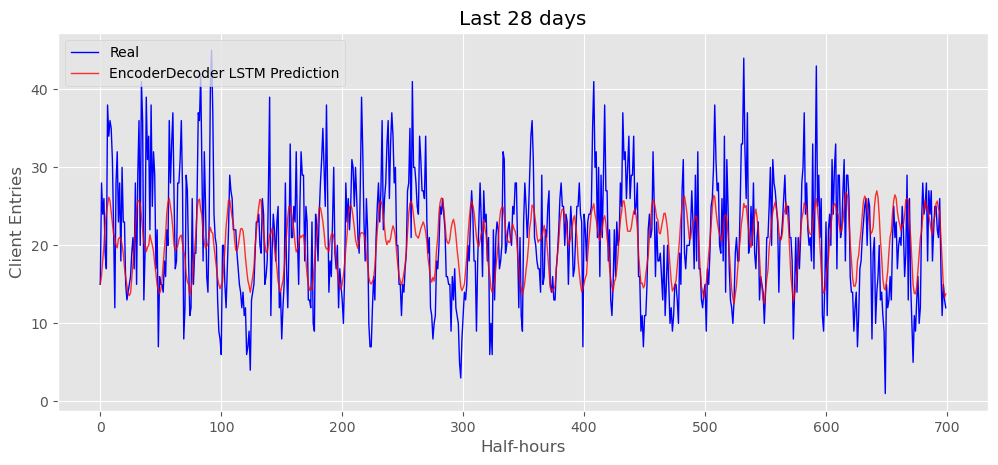

Each n_output score, iteration 1 
RMSE 6.325716290229325
MAE 4.9825773
MAPE 29.42996621131897
MAAPE 24.5992973446846 

The lower visualizations are only useful if walkforward (and multiple predictions) is employed


In [178]:
#%matplotlib notebook
# history of windows, is updated for each prediction
history = [x for x in train]

# save predictions
predictions = list()
for i in range(len(test)):
    # grid_search hyperparameters?
    # HERE
    
    # Time Series CROSS-VALIDATION
    # we don't need to retrain all the time though!
    print("walkforward expanding: %s" % (i+1))
    print("total expansions: %s" % (len(test)))
    # the model is trained and retrained for every number of n_output to predict
    if walkforward or i == 0:
        model = build_model(array(history), n_input, n_output, stride)  
        train_size = len(history)
    
    # predict the next n_output steps
    yhat_sequence = forecast(model, history, n_input)
    
    # invert the scaling on predictions
    yhat_sequence = invTransformTarget(scaler, yhat_sequence)
    
    # invert scaling for real values
    test_y = invTransformTarget(scaler, array(test[i, :, 0]).flatten())
    
    # invert the differencing
    if diff_order > 0:
        yhat_sequence = array(invert_difference(orig_dataset[train_size:train_size+diff_order], yhat_sequence, diff_order))
        test_y = array(invert_difference(orig_dataset[train_size:train_size+diff_order], test_y, diff_order))
   
    # give the seasonal and trend components back
    if remove_components:
        yhat_sequence = yhat_sequence + components[train_size:train_size+n_output]
        test_y = test_y + components[train_size:train_size+n_output]

        
    # store the predictions for later results
    predictions.append(yhat_sequence)
    
    # get real observation and add to history for predicting the next step, here recursive method can be used!
    history.append(test[i, :])
    
    
    #RENORMALIZE: after appending the real values back to the training data normalize again to not introduce bias
    if walkforward:
        arr_history = array(history)
        n_windows = arr_history.shape[0]
        n_features = arr_history.shape[2]
        arr_history = invTransformTarget(scaler, arr_history.flatten())
        arr_history = arr_history.reshape(n_windows*n_output,n_features)
        arr_history = normalize_train(scaler, arr_history)
        history = list(arr_history.reshape(n_windows, n_output, n_features))
        
    naive_yhat_sequence=dataset['clients_that_bought'].values[-1400-175+(175*i):-1400+(175*i)]
    # plot each iteration 
    pyplot.title('Last 28 days')
    pyplot.plot(test_y, color="blue", label="Real")
    pyplot.plot(yhat_sequence, alpha=0.8, color="red", label="EncoderDecoder LSTM Prediction")
    #pyplot.plot(naive_yhat_sequence, alpha=0.8, color="green", label="Naive Predicted")
    #pyplot.xticks([0, 25, 50, 75, 100, 125, 150, 175], labels=['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08'])
    #pyplot.xticks([0, 25, 50, 75, 100, 125, 150, 175], labels=['2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15'])
    #pyplot.xticks([0, 25, 50, 75, 100, 125, 150, 175], labels=['2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22'])
    #pyplot.xticks([0, 175, 350, 525, 700], labels=['2020-04-29', '2020-05-06', '2020-05-13', '2020-05-20', '2020-05-27'])
    pyplot.legend(loc="upper left")
    pyplot.xlabel("Half-hours")
    pyplot.ylabel("Client Entries")
    pyplot.show()
    
    # Score only from the each modelled n_output
    rmse = sqrt(mean_squared_error(test_y, yhat_sequence))
    mae = mean(abs(test_y - yhat_sequence))
    mape = mean(abs(test_y - yhat_sequence) / test_y) * 100
    maape = mean_arctangent_absolute_percentage_error(test_y, yhat_sequence)
    print('Each n_output score, iteration %s \nRMSE %s' % (i+1, rmse))
    print('MAE %s' % (mae))
    print('MAPE %s' % (mape))
    print('MAAPE %s \n' % (maape))
    
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png') 
# The question mark means that first dimension is not fixed in the graph and it can vary between run calls
print("The lower visualizations are only useful if walkforward (and multiple predictions) is employed")

In [179]:
#%tensorboard --logdir logs

In [180]:
# invert scaling for overall real values
test_y = invTransformTarget(scaler, array(test[:, :, 0]).flatten())

if diff_order > 0:
    test_y = array(invert_difference(orig_dataset[train_size:train_size+diff_order], test_y, diff_order))
        
# give the components back
if remove_components:
    test_y = test_y + components[-test_set:]
    
if walkforward:
    # plot overall predictions
    pyplot.title('EncoderDecoder LSTM related model')
    pyplot.plot(test_y, color="blue", label="Real")
    pyplot.plot(array(predictions).flatten(), alpha=0.8, color="red", label="LSTM Prediction")
    pyplot.legend(loc="upper left")
    pyplot.xlabel("Halves an hour")
    pyplot.ylabel("Receipts")
    pyplot.show()

In [181]:
# evaluate the predictions for each of the n_output steps

scores_rmse = list()
scores_mape = list()
scores_mae = list()
scores_maape = list()

predictions = array(predictions)
actual = array(test_y).reshape(predictions.shape[0], predictions.shape[1])
predicted = array(predictions)

# calculate the RMSE, MAPE, MAE and MAAPE for each step
for i in range(actual.shape[1]):
    
    #rmse, mape, mae and maape
    rmse = sqrt(mean_squared_error(actual[:, i], predicted[:, i]))
    mape = mean(abs(actual[:, i] - predicted[:, i]) / actual[:, i]) * 100
    mae = mean(abs(actual[:, i] - predicted[:, i]))
    maape = mean_arctangent_absolute_percentage_error(actual[:, i], predicted[:, i])

    
    # store the scores
    scores_rmse.append(rmse)
    scores_mape.append(mape)
    scores_mae.append(mae)
    scores_maape.append(maape)
# calculate the overall RMSE, MAPE, MAE and MAAPE (for all steps)
s_rmse = 0
s_mape = 0
s_mae = 0
s_maape = 0
for row in range(actual.shape[0]):
    for col in range(actual.shape[1]):
        s_rmse += (actual[row, col] - predicted[row, col]) ** 2
        s_mape += abs(actual[row, col] - predicted[row, col]) / actual[row, col]
        s_mae += abs(actual[row, col] - predicted[row, col])
        s_maape += arctan(abs((actual[row, col] - predicted[row, col]) / actual[row, col]))
        
score_rmse = sqrt(s_rmse / (actual.shape[0] * actual.shape[1]))
score_mape = 100 * s_mape / (actual.shape[0] * actual.shape[1])
score_mae = s_mae / (actual.shape[0] * actual.shape[1])
score_maape =  100 * s_maape / (actual.shape[0] * actual.shape[1]) 

EncoderDecoder LSTM: total_rmse [6.326] 
 RMSE 0.1, 11.9, 6.1, 6.0, 3.6, 7.2, 12.8, 7.8, 10.3, 10.7, 8.2, 0.6, 8.9, 8.0, 12.3, 2.2, 7.0, 2.8, 9.9, 4.0, 5.9, 0.9, 1.9, 0.2, 1.4, 2.1, 3.2, 3.4, 3.0, 5.9, 9.7, 3.2, 10.3, 5.4, 17.3, 13.9, 7.3, 1.3, 19.8, 11.3, 14.0, 0.6, 17.4, 5.0, 12.7, 11.4, 0.6, 7.1, 7.4, 2.2, 0.7, 0.6, 3.6, 1.5, 5.4, 2.2, 5.5, 10.0, 3.0, 9.2, 14.9, 6.1, 2.4, 1.6, 8.1, 7.2, 9.8, 14.7, 6.8, 11.2, 6.6, 12.7, 11.7, 3.0, 2.6, 2.4, 10.7, 2.6, 0.5, 2.4, 1.4, 11.3, 10.1, 17.4, 6.1, 3.7, 11.7, 5.4, 3.9, 6.2, 1.5, 17.7, 23.3, 15.5, 4.1, 2.5, 2.8, 2.8, 6.0, 6.4, 9.0, 4.8, 2.8, 4.5, 10.4, 7.0, 3.8, 3.2, 2.3, 2.4, 0.9, 1.3, 2.6, 0.3, 2.9, 6.0, 8.1, 10.2, 7.8, 9.4, 6.4, 10.9, 8.5, 5.8, 10.0, 1.9, 2.0, 2.1, 1.0, 1.4, 0.6, 0.9, 5.9, 6.7, 2.7, 2.3, 5.3, 3.1, 1.1, 6.9, 17.6, 10.4, 3.2, 2.6, 2.2, 0.6, 5.9, 9.6, 2.5, 0.1, 6.8, 3.5, 1.9, 8.8, 4.4, 11.6, 5.0, 8.1, 3.2, 2.3, 2.9, 2.7, 12.8, 1.4, 4.9, 3.8, 11.0, 7.7, 7.6, 2.0, 6.8, 6.8, 2.0, 1.2, 2.6, 8.7, 5.7, 8.5, 4.5, 0.5, 5.0, 0.9, 3.2, 7

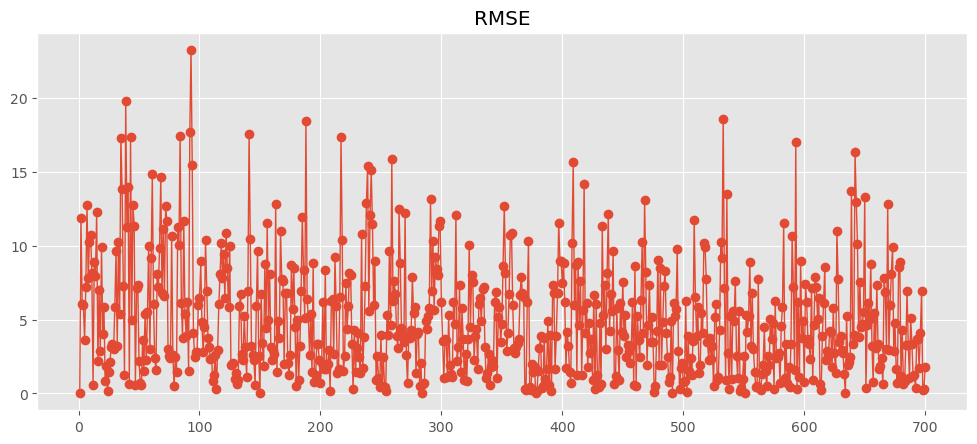

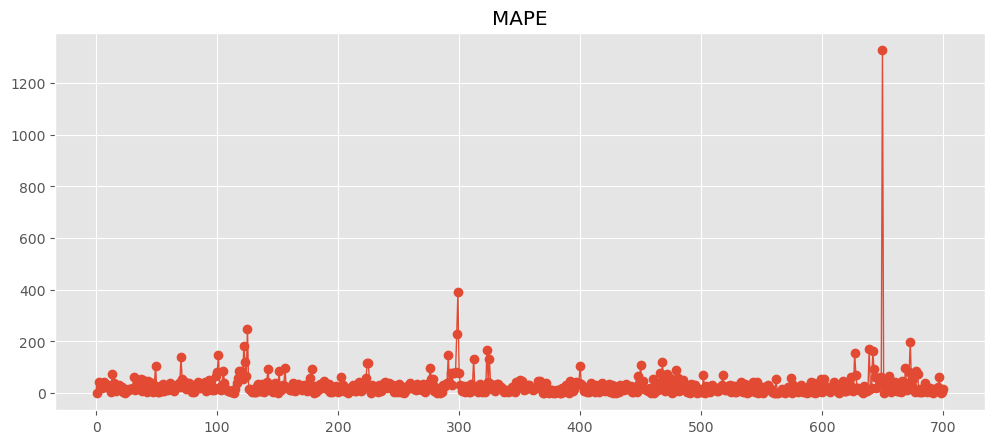

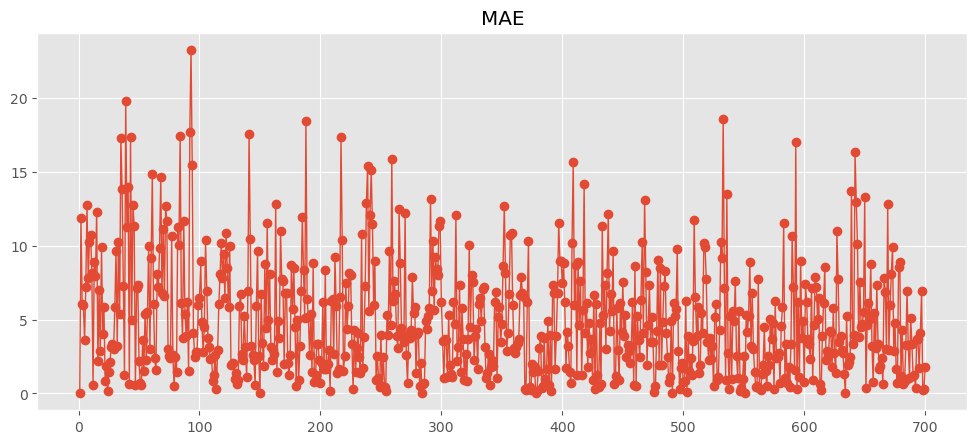

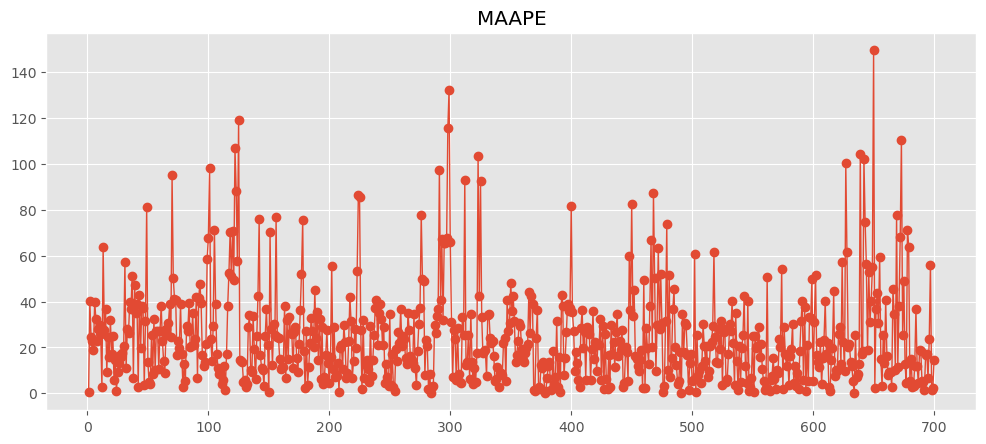

In [182]:
# Summarize the RMSE, MAPE, MAE and MAAPE scores
name = 'EncoderDecoder LSTM'
s_scores_rmse = ', '.join(['%.1f' % s for s in scores_rmse])
s_scores_mape = ', '.join(['%.1f' % s for s in scores_mape])
s_scores_mae = ', '.join(['%.1f' % s for s in scores_mae])
s_scores_maape = ', '.join(['%.1f' % s for s in scores_maape])

print('%s: total_rmse [%.3f] \n RMSE %s' % (name, score_rmse, s_scores_rmse))
print('%s: total_mae [%.3f] \n MAE %s' % (name, score_mae, s_scores_mae))
print('%s: total_mape [%.3f] \n MAPE %s' % (name, score_mape, s_scores_mape))
print('%s: total_maape [%.3f] \n MAAPE %s' % (name, score_maape, s_scores_maape))

# Plotting of the scores for each step

forward_steps = list(range(1, n_output + 1))
pyplot.title('RMSE')
pyplot.plot(forward_steps, scores_rmse, marker='o')
pyplot.show()
pyplot.title('MAPE')
pyplot.plot(forward_steps, scores_mape, marker='o')
pyplot.show()
pyplot.title('MAE')
pyplot.plot(forward_steps, scores_mae, marker='o')
pyplot.show()
pyplot.title('MAAPE')
pyplot.plot(forward_steps, scores_maape, marker='o')
pyplot.show()